# Homework 4 : Observational Studies and Applied ML

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from matplotlib import gridspec
plt.style.use('fivethirtyeight')
import scipy.stats.mstats as stat

from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

import networkx as nx
from networkx.algorithms import bipartite

## Q1. Propensity score matching

We have a dataset (`lalonde`) of an observational study and wish to comment on the effectiveness of a treatment program on the income of a group of people. 

The dataset contains the following information : 
- `id` : anonymised id for the worker
- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

In [2]:
# importing data
data = pd.read_csv('lalonde.csv')

We complete the one-hot encoding of ethnicity by adding another column denoting `white` ethnicity, that will be useful later on for logistic regression. Also, we add a column with the `ethnicity` and `treatment` which will be useful for the pie charts we will show later on.

In [3]:
data['white'] = 1
data['ethnicity'] = 'White'
data['treatment'] = 'Treated'
data.loc[data['black']==1, 'ethnicity'] = 'Black'
data.loc[data['hispan']==1, 'ethnicity'] = 'Hispanic' 
data.loc[data['treat']==0, 'treatment'] = 'Control' 
data.loc[data['black']==1, 'white'] = 0 
data.loc[data['hispan']==1,'white'] = 0
data.head(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white,ethnicity,treatment
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0,Black,Treated
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0,Hispanic,Treated
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0,Black,Treated
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0,Black,Treated
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0,Black,Treated
5,NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940,0,Black,Treated
6,NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000,0,Black,Treated
7,NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580,0,Black,Treated
8,NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220,0,Black,Treated
9,NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.0700,1,White,Treated


Now we divide the dataset into two dataframes based on whether they received the treatment or not.

In [4]:
# Divide the dataset based on group (people who received the treatment vs control)
treated = data[data['treat'] == 1].reset_index()
control = data[data['treat'] == 0]
print('There are {} people in the study, out of which {} were treated and {} were control.'.format(len(data),len(treated), len(control)))

There are 614 people in the study, out of which 185 were treated and 429 were control.


### 1. Naïve analysis 
We will pretend to be naïve and try to show the differences in distributions of the income in 1978 (`re78`) between the two groups, using plots and numbers. 

unobserved covariates ->  Naive model: exclude them because assume “Only observed variables determine treatment assignment”. Bad, naive model is almost never true. -> Use propensity score.
"Adjustments using a model attempt to compare people who are not directly
comparable — people of somewhat different ages or smoking habits — removing
these differences using a mathematical structure that has elements estimated from
the data at hand."


Propensity score -> "if naive model is true, it equals the probability to treat"
e(x) = P(Z=1|x)
Computed by logistic regression. Features x, label Z



In [5]:
# function for plotting
def plot_box_hist(data_to_plot,labels,bins):
    # Boxplot
    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
    plt.subplot(gs[0])
    plot = plt.boxplot(data_to_plot, 1, widths=0.5)
    plt.ylabel(labels['plotlabel'])
    plt.xlabel('Group')
    plt.xticks([1, 2], ['Treated', 'Control'])
    plt.title(labels['boxtitle'])
    
    # Distribution (histogram)
    plt.subplot(gs[1])
    plt.hist(data_to_plot[0],alpha=0.6, weights=np.zeros_like(data_to_plot[0]) + 1. / data_to_plot[0].size, bins = bins[0])
    plt.hist(data_to_plot[1],alpha=0.6, weights=np.zeros_like(data_to_plot[1]) + 1. / data_to_plot[1].size, bins = bins[1]) 
    plt.xlabel(labels['plotlabel'])
    plt.ylabel('Proportion of people')
    plt.legend(['Treated','Control'])
    plt.title(labels['histtitle'])

    plt.show()

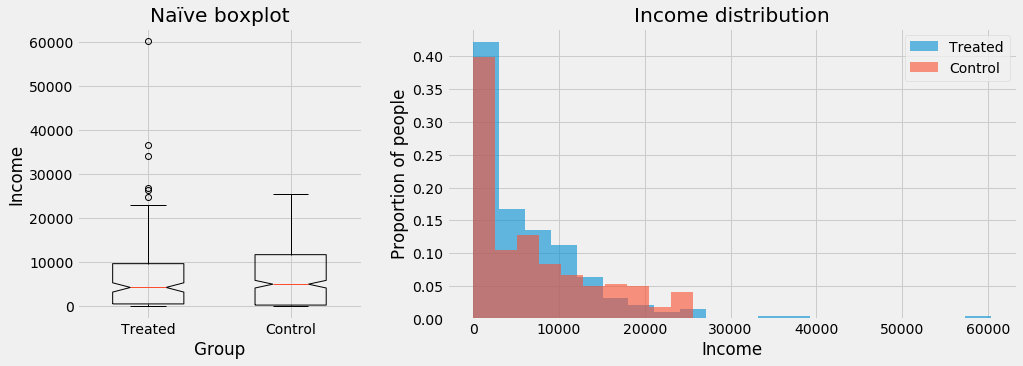

In [6]:
data_to_plot = [treated.loc[:,'re78'], control.loc[:,'re78']]

labels = {'plotlabel': 'Income',\
         'boxtitle': 'Naïve boxplot',\
         'histtitle':'Income distribution'}

plot_box_hist(data_to_plot,labels,[20,10])

The boxplot notch show considerable overlap, we cannot conclude about the difference of medians. The naïve researcher would say this is ineffective or perhaps even harmful. But we should not forget to ask the following questions: 

* Do the two groups come from the same social background?
* Were they having the same income before the treatment?
* Do other features like age, education etc affect the treatment?

Observational studies suffer from this tendency to draw conclusions without looking at the underlying factors properly. We will look at the distributions of the pre-treatment variables (features) to try and address these questions in the following section "_A closer look at the data_"

### 2. A closer look at the data

First, we plot the data of the non-categorical variables and show how the treated and untreated populations differ (or not) in terms of these variables.

We first look at the non-categorical variables, namely Age, Years of Education and pre-treatment incomes (Income in 1974 and Income in 1975)

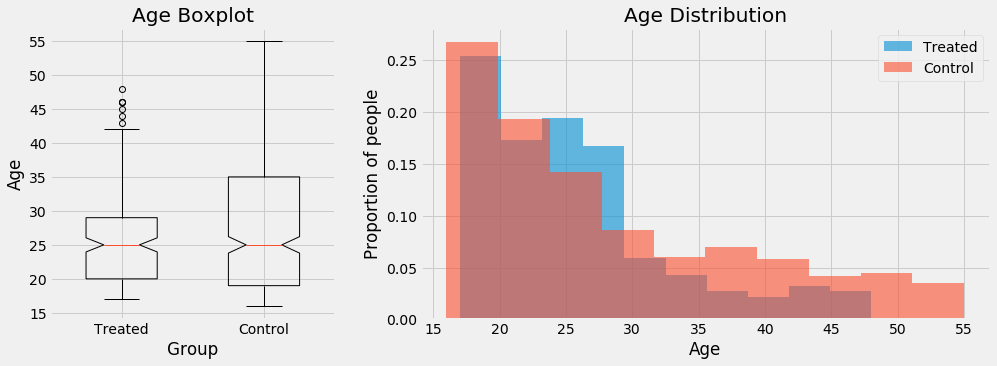

In [7]:
data_to_plot = [treated.loc[:,'age'], control.loc[:,'age']]

labels = {'plotlabel': 'Age',\
         'boxtitle': 'Age Boxplot',\
         'histtitle':'Age Distribution'}

plot_box_hist(data_to_plot,labels, [10,10])

In terms of age, the medians and notches are overlapping, but the control group has a heavy-tailed distribution as seen. The distribution of the control group also has lesser number of outliers.

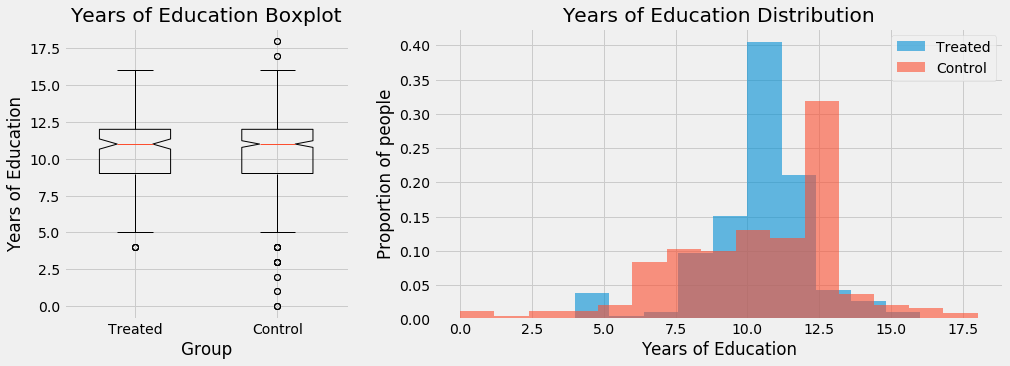

In [8]:
data_to_plot = [treated.loc[:,'educ'], control.loc[:,'educ']]

labels = {'plotlabel': 'Years of Education',\
         'boxtitle': 'Years of Education Boxplot',\
         'histtitle':'Years of Education Distribution'}

plot_box_hist(data_to_plot,labels, [10,15])

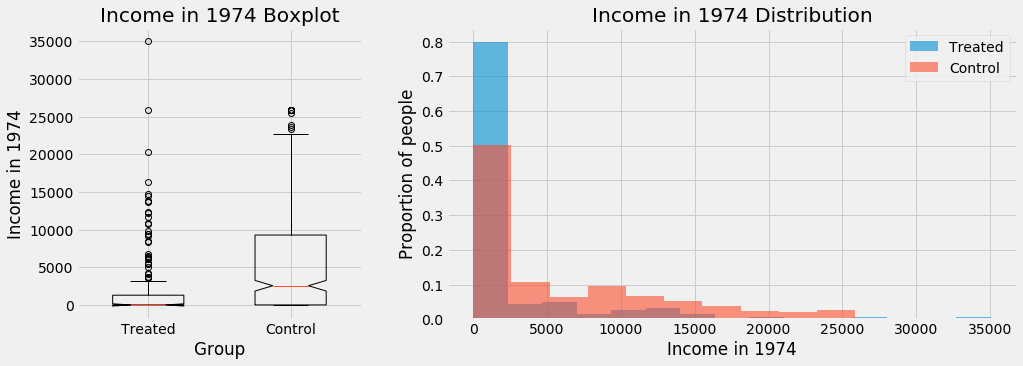

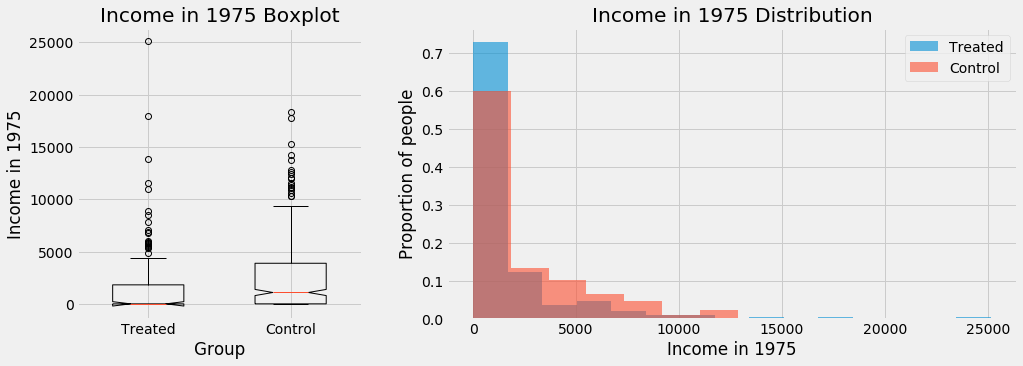

In [9]:
data_to_plot = [treated.loc[:,'re74'], control.loc[:,'re74']]

labels = {'plotlabel': 'Income in 1974',\
         'boxtitle': 'Income in 1974 Boxplot',\
         'histtitle':'Income in 1974 Distribution'}

plot_box_hist(data_to_plot,labels, [15,10])

data_to_plot = [treated.loc[:,'re75'], control.loc[:,'re75']]

labels = {'plotlabel': 'Income in 1975',\
         'boxtitle': 'Income in 1975 Boxplot',\
         'histtitle':'Income in 1975 Distribution'}

plot_box_hist(data_to_plot,labels, [15,10])

We see that there is a significant difference between the Treated and the Control groups in terms of the median notches when it comes to Income in both the years 1974 and 1975. Also, there is a large proportion of people with 0 income in both the groups, especially so in the Treated group. This makes sense as unemployed people _would_ be the ones to take advantage of the treatment program. While this difference exists, it is expected, but the control group should also have had more similar distributions, which is not seen in this case.

The boxplot and distribution show that in terms of years of education also, the data is similarly distributed. Howeverm there are more outliers in the control group here as well.

_**A look at the categorical variables**_

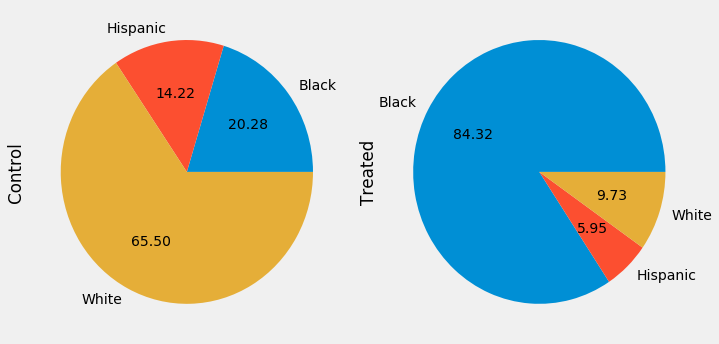

In [10]:
ethnicity = data.groupby(['ethnicity','treatment']).size().unstack(fill_value=0)
ethnicity.plot(kind = 'pie',\
               subplots = True,\
               use_index = False,\
               legend = None,\
               autopct='%.2f',\
               figsize=(10,5))
plt.tight_layout()

But if we look at the two groups in case of ethnicity, it seem to be _**unbalanced**_. The treated population is overwhelmingly black while the untreated population is mostly white. The other categorical variables are shown below.

In [ ]:
ethnicity = data.groupby(['married','treatment']).size().unstack(fill_value=0)
ethnicity.plot(kind = 'pie',\
               subplots = True,\
               use_index = False,\
               legend = False,\
               labels = ['Unmarried', 'Married'],\
               autopct='%.2f',\
               figsize=(10,5))
plt.tight_layout()

In [ ]:
ethnicity = data.groupby(['nodegree','treatment']).size().unstack(fill_value=0)
ethnicity.plot(kind = 'pie',\
               subplots = True,\
               use_index = False,\
               legend = False,\
               labels = ['With a degree','No degree'],\
               autopct='%.2f',\
               figsize=(10,5))
plt.tight_layout()

We see that there is also a significant difference in the distribution in terms of marital status between the treated and the control group. There is some difference in the case of degrees obtained as well (59.67% versus 70.81% with no degree in the control and treated groups respectively)

_**Observation**_ : The factors of **ethnicity**, **martial status** and to some extent, **degree ownership** as well as **initial income data** are different in terms of distribution between the control and treated groups. So, naïvely concluding that the treatment is not succesful might be wrong, as we would need a better sample in the observational study which gives us a more similarly distributed population between the control and treated groups

### 3. A propensity score model
At this point, we need to interpolate the data in order to obtain two populations of the same characteristic, which do not differ so much in the variable distribution. To do so, we are going to match the data the propensity score. Under the assumption that only observed variables determine treatment assignment, the propensity score represents the probability of receiving the treatment, given the pre-treatement features. Our pre-treatment features include `age`, `educ`, one-hot encoding for the ethnicity (`black`, `hispan`, `white`), `married`, `nodegree` and the two incomes `re74` and `re75`.

First, we choose only the required features from the dataset.

In [ ]:
#features and labels
y = np.array(data.treat)
X = data.drop(['id', 'treat','re78','ethnicity','treatment'],axis=1)
X.head(10)

We use logistic regression to estimate the propensity scores

In [ ]:
logistic = linear_model.LogisticRegression()  # create the model
logistic.fit(X, y);  # train it

#Predict
yhat = cross_val_predict(logistic, X, y, cv=5)

# Select only the probability to be treated (1)
data['propens'] = logistic.predict_proba(X)[:,1]

Let's see just for its own sake how the model performs. For this we will implement an error function which balances the two classes.

In [ ]:
#Check the class error
classes = np.unique(y);
err = np.zeros(len(classes));

for c in range(len(classes)):
    err[c] = sum((y!=yhat) & (y == classes[c]))/sum(y==classes[c]);

err = np.mean(err);
err

In [ ]:
data.head(10)

### 4. Balancing the dataset via matching
We now use the `networkx` package to create a bipartite graph from the dataset. The vertices of one set in the graph consist of the treated group and the other set are the control group. The `id`s would be needed to find in the dataset, later on. Before we do the calculation for the whole group, we show a small diagram which illustrates the bipartite graph and shows what we are doing.

In [ ]:
B_treated_small = list(treated.id)[:4]
B_control_small = list(control.id)[:4]

# initialise the graph
B_small = nx.Graph()

# add nodes
B_small.add_nodes_from(B_treated_small, bipartite=0)
B_small.add_nodes_from(B_control_small, bipartite=1)

# add edges
for b_treated in B_treated_small:
    for b_control in B_control_small:
        wt =  -np.abs(data[data['id']==str(b_treated)].propens.values - data[data['id']==str(b_control)].propens.values)
        B_small.add_edge(b_treated,b_control,weight = wt)

In [ ]:
## Visualise the small bipartite graph with thickness corresponding to the abs. difference between propensity scores
## scaled up to look prominent

edgewidth = np.abs([d['weight'] for (u,v,d) in B_small.edges(data=True)])[:,0]*3
X, Y = bipartite.sets(B_small)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
nx.draw(B_small, pos=pos, width = edgewidth)
plt.show()

In [ ]:
%%time
d = nx.algorithms.max_weight_matching(B_small,maxcardinality=True)

In [ ]:
B_new_small = nx.Graph()
B_new_small.add_nodes_from(B_treated_small, bipartite=0)
B_new_small.add_nodes_from(B_control_small, bipartite=1)

# add edges
for key in d.keys():
    if (str(key)[0]=='N'):
        print(key, d[key])
        wt =  -np.abs(data[data['id']==str(key)].propens.values - data[data['id']==str(d[key])].propens.values)
        B_new_small.add_edge(key,d[key],weight = wt)

In [ ]:
X, Y = bipartite.sets(B_new_small)

In [ ]:
edgewidth = np.abs([d['weight'] for (u,v,d) in B_new_small.edges(data=True)])[:,0]*3
X, Y = bipartite.sets(B_new_small)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
nx.draw(B_new_small, pos=pos, width = edgewidth)
plt.show()

In [ ]:
X, Y = bipartite.sets(d)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
nx.draw(d, pos=pos, width = weights)
plt.show()

In [ ]:
B_treated = list(treated.id)
B_control = list(control.id)

In [ ]:
# let's create a graph
B = nx.Graph()
B.add_nodes_from(B_treated, bipartite=0)
B.add_nodes_from(B_control, bipartite=1)

We add the edges as the negative of the absolute differences between the propensity scores of the vertices. The edges only run from one set to the other (by the definition of a bipartite graph) which we will check later on after the edges are entered. We need the negative of the absolute differences because the algorithm we will use to optimise and find a matching would find the maximum weighted full cardinality matching (thus maxing out to correspond 

In [ ]:
%%time
for b_treated in B_treated:
    for b_control in B_control:
        wt =  -np.abs(data[data['id']==str(b_treated)].propens.values - data[data['id']==str(b_control)].propens.values)
        B.add_edge(b_treated,b_control,weight = wt)

In [ ]:
nx.is_bipartite(B)

In [ ]:
print('Nodes:', len(B.nodes()))
print('Edges:', len(B.edges()))
print('The total number of edges correspond to', len(B_treated), '(N treated) *', len(B_control),  '(N control)')

In [ ]:
%%time
d = nx.algorithms.max_weight_matching(B,maxcardinality=True)

In [ ]:
df = pd.DataFrame()
for key in d.keys():
    df = pd.concat([df, data[data['id']==key]])

In [ ]:
df_t = df[df['treat']==1]
df_nt = df[df['treat']==0]
data_to_plot = [df_t[data['nodegree']==0].loc[:,'re78'], df_nt[data['nodegree']==0].loc[:,'re78']]
plot = plt.boxplot(data_to_plot)